# TP1 : First order methods on regression models

#### Authors: S. Gaiffas, A. Gramfort

## Aim

The aim of this material is to code 
- proximal gradient descent (ISTA)
- accelerated gradient descent (FISTA) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- ridge penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 9th of october at 23:59**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called **Rendu TP du 3 octobre 2016**. This is where you submit your jupyter notebook file. 
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "côme"
ln1 = "arvis"
fn2 = "guillaume"
ln2 = "ligner"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp1_arvis_côme_and_ligner_guillaume.ipynb


In [2]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [3]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

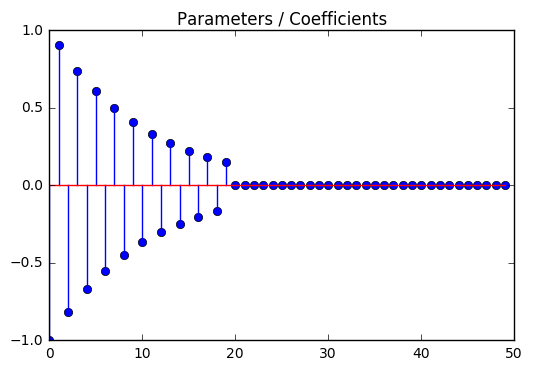

In [4]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = (-1) ** (idx - 1) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [5]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz
from numpy.random import randn


def simu_linreg(coefs, n_samples=1000, corr=0.2):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A_lin = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b_lin = A_lin.dot(coefs) + randn(n_samples)
    return A_lin, b_lin

def sigmoid(t):
    """Sigmoid function (overflow-proof)"""
    idx = t > 0
    out = np.empty(t.size)
    out[idx] = 1. / (1 + np.exp(-t[idx]))
    exp_t = np.exp(t[~idx])
    out[~idx] = exp_t / (1. + exp_t)
    return out

def simu_logreg(coefs, n_samples=1000, corr=0.2):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape=(n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation of the features

    Returns
    -------
    A : `numpy.ndarray`, shape=(n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape=(n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A_log = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A_log.dot(coefs))
    b_log = np.random.binomial(1, p, size=n_samples)
    b_log[:] = 2 * b_log - 1
    return A_log, b_log

## Part 1 : Proximal operators

We remind that the proximal operator of a fonction $g$ is given by:

$$
\text{prox}_g(y, t) = \arg\min_x \Big\{ \frac 12 \|x - y\|_2^2 + t g(x) \Big\}.
$$

where $t \geq 0$ is a non-negative number.
We have in mind to use the following cases

- Ridge penalization, where $g(x) = \frac{s}{2} \|x\|_2^2$
- Lasso penalization, where $g(x) = s \|x\|_1$

where $s \geq 0$ is a regularization parameter.

## Questions

- Code a function that computes $g(x)$ in both cases and $\text{prox}_g(x)$ for ridge and  lasso penalization (use the slides of the first course to get the formulas), using the prototypes given below
- Visualize the functions applied element wise by the proximity operators of the Ridge and Lasso 

In [6]:
def prox_lasso(x, s, t=1.):
    """Proximal operator for the Lasso at x with strength t"""    
    return ( np.sign(x) * np.maximum(np.absolute(x) - s*t, np.zeros(x.size)) )

def lasso(x, s):
    """Value of the Lasso penalization at x with strength t"""
    return s * np.linalg.norm(x, ord=1)

def prox_ridge(x, s, t=1.):
    """Proximal operator for the ridge at x with strength t"""
    return ( (1 / (1 + s*t)) * x )

def ridge(x, s):
    """Value of the ridge penalization at x with strength t"""
    return (s/2) * np.power(np.linalg.norm(x, ord=2), 2)

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2, 2)

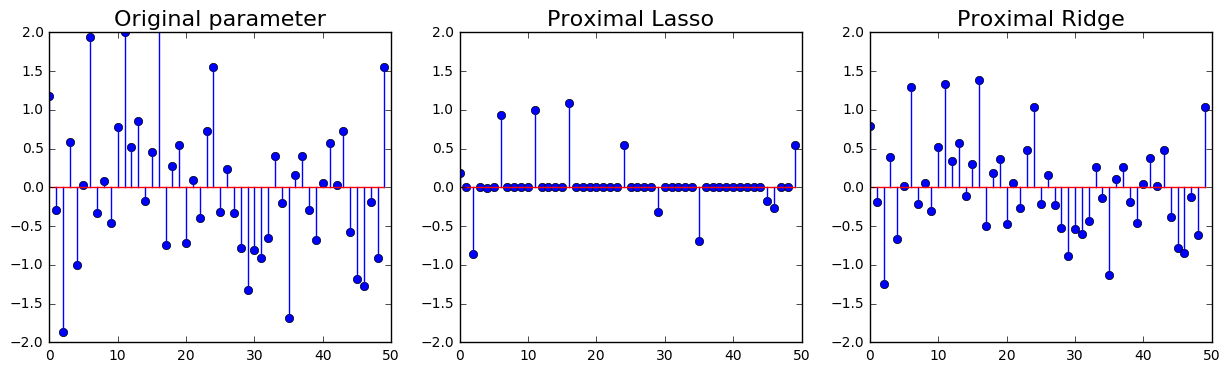

In [7]:
x = randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_lasso(x, s=l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim([-2, 2])

## Question

- Comment what you observe (1 or 2 sentences).

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + g(x)
$$
where $f$ is $L$-smooth and $g$ is prox-capable.

We will consider below the following cases

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A$ is the matrix of features.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

**Questions**:
- Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)
- Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.
- Check that these functions are correct by numerically checking the gradient, using the function ``checkgrad`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model

## Part 3: Solvers

In [8]:
def loss_linreg(x):
    """Least-squares loss"""
    result = (1/ (2 * n)) * np.power(np.linalg.norm(b_lin - A_lin.dot(x), ord=2), 2)
    return result

def grad_linreg(x):
    """Leas-squares gradient"""
    result = (1/n) * A_lin.T.dot(A_lin.dot(x) - b_lin)
    return result

def loss_logreg(x):
    """Logistic loss"""
    temp = 0
    for i in range (n):
        temp += np.log(1 + np.exp( -b_log[i] * x.T.dot(A_log[i]) ))
    result = temp / n
    return result

def grad_logreg(x):
    """Logistic gradient"""
    result = (-(1 - sigmoid( b_log * x.dot(A_log.T).T )) * b_log).T.dot(A_log)
    result /= n
    return result.T

In [9]:
n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n)
A_log, b_log = simu_logreg(coefs, n_samples = n)

In [10]:
from scipy.optimize import check_grad

print(check_grad(loss_linreg, grad_linreg, np.zeros(50)))
print(check_grad(loss_logreg, grad_logreg, np.zeros(50)))

2.56946107961e-07
6.19440047486e-06


We know have a function to compute $f$, $\nabla f$ and $g$ and $\text{prox}_g$. 

We want now to code the Ista and Fista solvers to minimize

$$
\arg\min_x f(x) + g(x)
$$

**Questions**:

- Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function `numpy.linalg.norm` (read the documentation
  of the function)

- Finish the functions `ista` and `fista` below that implements the 
  ISTA (Proximal Gradient Descent) and FISTA (Accelerated Proximal 
  Gradient Descent) algorithms

In [11]:
def lip_linreg(A_lin):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A_lin.T.dot(A_lin))/n
    
def lip_logreg(A_log):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(A_log.T.dot(A_lin))/(4*n)
    
def ista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50, x_true=coefs, verbose=True, store=True):
    """Proximal gradient descent algorithm
    """
    
    list_x_ista = []
    
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A_lin.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    if verbose:
        print ('Lauching ISTA solver...')
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
        
    for k in range(n_iter + 1):

        x_new[:] = prox_g(x - step * grad_f(x), s*step)
        x[:] = x_new
                
        list_x_ista.append(x.copy())
                                
        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return list_x_ista, x, objectives, errors

In [12]:
def fista(x0, f, grad_f, g, prox_g, step, s=0., n_iter=50, x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    
    list_x_fista = []
    
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for FISTA
    z = x0.copy()
    n_samples, n_features = A_lin.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true, ord = 2) / np.linalg.norm(x_true, ord = 2)
    errors.append(err)
    # Current objective
    obj = f(x) + g(x, s)
    objectives.append(obj)
    t = 1.
    t_new = 1.    
    if verbose:
        print ('Lauching FISTA solver...')
        print (' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        x_new[:] = prox_g(z - step * grad_f(z), s*step)
        z[:] = x_new + (t - 1) / t_new * (x_new - x)
        t_new = (1. + (1. + 4. * t * t)) ** (0.5) / 2.
        t = t_new
        x[:] = x_new
        
        list_x_fista.append(x.copy())

        obj = f(x) + g(x, s)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print (' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return list_x_fista, x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [13]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2

step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)


print("BEGIN LINEAR RIDGE")
list_x_istaR, x_istaR, obj_istaR, err_istaR = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
list_x_fistaR, x_fistaR, obj_fistaR, err_fistaR = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
print("END")

print("BEGIN LINEAR LASSO")
list_x_istaL, x_istaL, obj_istaL, err_istaL = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
list_x_fistaL, x_fistaL, obj_fistaL, err_fistaL = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
print("END")

print("BEGIN LOG RIDGE")
list_x_istaR2, x_istaR2, obj_istaR2, err_istaR2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
list_x_fistaR2, x_fistaR2, obj_fistaR2, err_fistaR2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
print("END")

print("BEGIN LOG LASSO")
list_x_istaL2, x_istaL2, obj_istaL2, err_istaL2 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
list_x_fistaL2, x_fistaL2, obj_fistaL2, err_fistaL2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
print("END")


BEGIN LINEAR RIDGE
END
BEGIN LINEAR LASSO
END
BEGIN LOG RIDGE
END
BEGIN LOG LASSO
END


**Questions**

- Compute a precise minimum and a precise minimizer of the linear regression with ridge 
  penalization problem using the parameters give above. This can be done by using fista with 
  1000 iterations.
- Compare the convergences of ISTA and FISTA, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.

**Questions**

- In linear regression and logistic regression, study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, study the influence of the level of ridge 
  penalization on the performance of the optimization algorithms. Explain.

- In linear regression and logistic regression, compare the performance of the optimization
  algorithms for ridge and lasso penalizations. Explain

In [14]:
dust1, minimizerR, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, 1000, coefs, False)
minimumR = loss_linreg(minimizerR) + ridge(minimizerR, s)
print('Minimizer of the linear regression with ridge penalization:\n')
print(minimizerR)
print('\nMinimum of f + g obtained:\n')
print(minimumR)

dust1, minimizerL, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, 1000, coefs, False)
minimumL = loss_linreg(minimizerL) + lasso(minimizerL, s)
dust1, minimizerR2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, 1000, coefs, False)
minimumR2 = loss_logreg(minimizerR2) + ridge(minimizerR2, s)
dust1, minimizerL2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, 1000, coefs, False)
minimumL2 = loss_logreg(minimizerL2) + lasso(minimizerL2, s)

Minimizer of the linear regression with ridge penalization:

[ -9.97e-01   9.31e-01  -8.05e-01   7.25e-01  -6.00e-01   6.32e-01
  -5.78e-01   5.85e-01  -4.17e-01   3.37e-01  -4.13e-01   3.25e-01
  -2.91e-01   2.57e-01  -2.32e-01   2.55e-01  -2.37e-01   2.72e-01
  -1.29e-01   1.97e-01  -4.73e-02   4.70e-02  -5.78e-02   8.45e-02
   3.35e-02   5.21e-03  -4.45e-03  -4.01e-02   2.80e-02  -1.02e-02
  -7.16e-04  -3.13e-02  -2.17e-03   1.32e-02   1.56e-02  -3.19e-03
   2.05e-02  -3.88e-02   4.24e-02  -3.35e-02  -1.06e-03  -5.81e-03
   1.80e-02   3.69e-02   1.64e-02  -2.70e-02  -2.44e-02  -2.43e-02
  -7.05e-05  -3.30e-02]

Minimum of f + g obtained:

0.487629588871


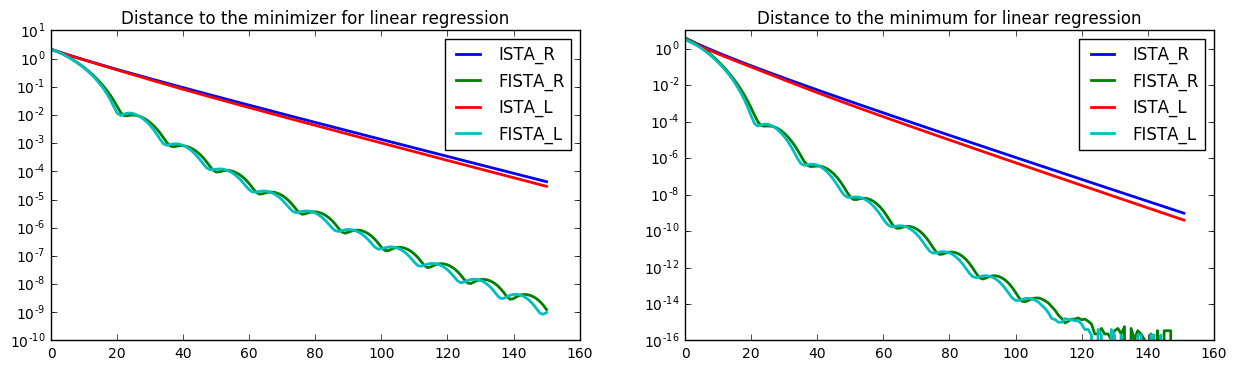

In [15]:
minimizer_istaR = []
minimizer_fistaR = []
minimizer_istaL = []
minimizer_fistaL = []
minimizer_istaR2 = []
minimizer_fistaR2 = []
minimizer_istaL2 = []
minimizer_fistaL2 = []

for i in range(0, len(list_x_istaR)):
    minimizer_istaR.append(np.linalg.norm(list_x_istaR[i] - minimizerR, ord = 2))
    minimizer_fistaR.append(np.linalg.norm(list_x_fistaR[i] - minimizerR, ord = 2))
    minimizer_istaL.append(np.linalg.norm(list_x_istaL[i] - minimizerL, ord = 2))
    minimizer_fistaL.append(np.linalg.norm(list_x_fistaL[i] - minimizerL, ord = 2))
    minimizer_istaR2.append(np.linalg.norm(list_x_istaR2[i] - minimizerR2, ord = 2))
    minimizer_fistaR2.append(np.linalg.norm(list_x_fistaR2[i] - minimizerR2, ord = 2))
    minimizer_istaL2.append(np.linalg.norm(list_x_istaL2[i] - minimizerL2, ord = 2))
    minimizer_fistaL2.append(np.linalg.norm(list_x_fistaL2[i] - minimizerL2, ord = 2))
    
minimum_istaR = (obj_istaR - minimumR)/np.absolute(minimumR)
minimum_fistaR = (obj_fistaR - minimumR)/np.absolute(minimumR)
minimum_istaL = (obj_istaL - minimumL)/np.absolute(minimumL)
minimum_fistaL = (obj_fistaL - minimumL)/np.absolute(minimumL)
minimum_istaR2 = (obj_istaR2 - minimumR2)/np.absolute(minimumR2)
minimum_fistaR2 = (obj_fistaR2 - minimumR2)/np.absolute(minimumR2)
minimum_istaL2 = (obj_istaL2 - minimumL2)/np.absolute(minimumL2)
minimum_fistaL2 = (obj_fistaL2 - minimumL2)/np.absolute(minimumL2)
    
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(minimizer_istaR, label="ISTA_R", lw=2)
plt.plot(minimizer_fistaR, label="FISTA_R", lw=2)
plt.plot(minimizer_istaL, label="ISTA_L", lw=2)
plt.plot(minimizer_fistaL, label="FISTA_L", lw=2)
plt.title("Distance to the minimizer for linear regression")
plt.legend()
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(minimum_istaR, label="ISTA_R", lw=2)
plt.plot(minimum_fistaR, label="FISTA_R", lw=2)
plt.plot(minimum_istaL, label="ISTA_L", lw=2)
plt.plot(minimum_fistaL, label="FISTA_L", lw=2)
plt.title("Distance to the minimum for linear regression")
plt.legend()

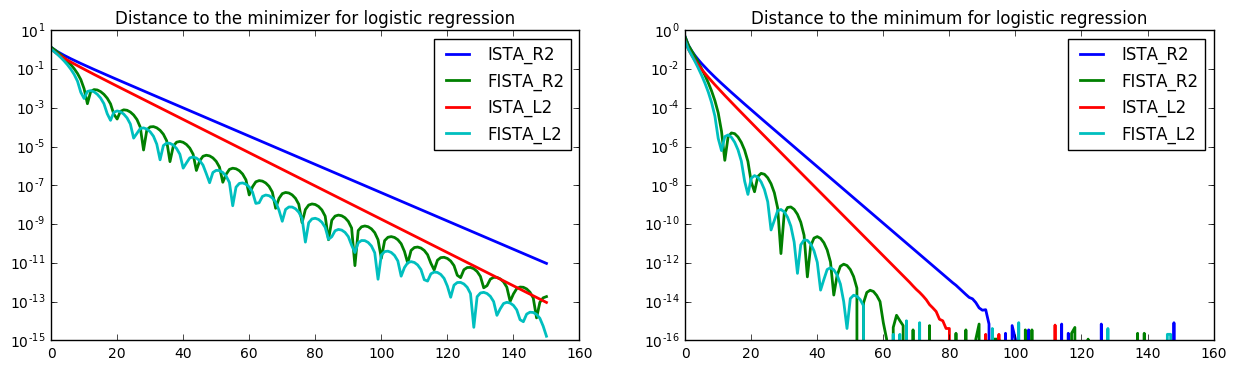

In [16]:
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(minimizer_istaR2, label="ISTA_R2", lw=2)
plt.plot(minimizer_fistaR2, label="FISTA_R2", lw=2)
plt.plot(minimizer_istaL2, label="ISTA_L2", lw=2)
plt.plot(minimizer_fistaL2, label="FISTA_L2", lw=2)
plt.title("Distance to the minimizer for logistic regression")
plt.legend()
plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(minimum_istaR2, label="ISTA_R2", lw=2)
plt.plot(minimum_fistaR2, label="FISTA_R2", lw=2)
plt.plot(minimum_istaL2, label="ISTA_L2", lw=2)
plt.plot(minimum_fistaL2, label="FISTA_L2", lw=2)
plt.title("Distance to the minimum for logistic regression")
plt.legend()

Globaly, we see that the convergence rate is stronger for FISTA than ISTA algorithm

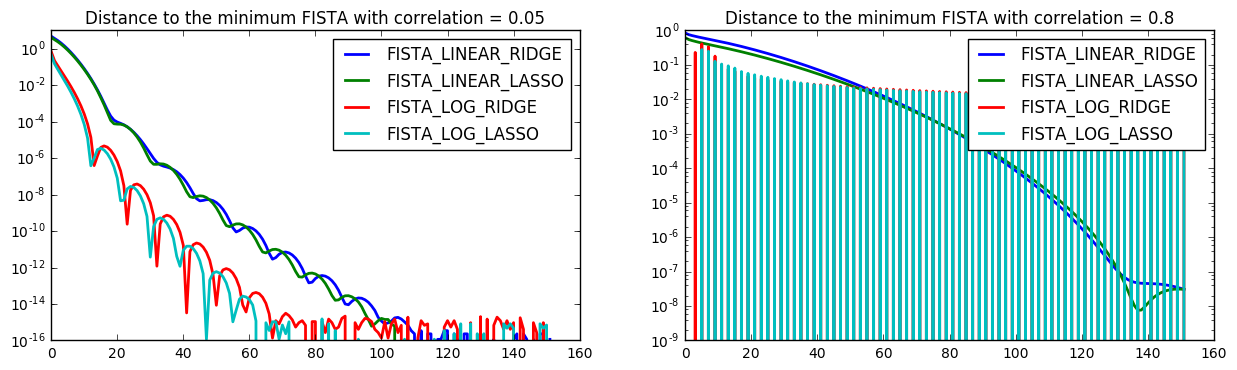

In [17]:
n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.05)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.05)


x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)

dust1, minimizerR, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, 1000, coefs, False)
minimumR = loss_linreg(minimizerR) + ridge(minimizerR, s)
dust1, minimizerL, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, 1000, coefs, False)
minimumL = loss_linreg(minimizerL) + lasso(minimizerL, s)
dust1, minimizerR2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, 1000, coefs, False)
minimumR2 = loss_logreg(minimizerR2) + ridge(minimizerR2, s)
dust1, minimizerL2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, 1000, coefs, False)
minimumL2 = loss_logreg(minimizerL2) + lasso(minimizerL2, s)



'''_LINEAR_RIDGE'''
list_x_istaR, x_istaR, obj_istaR, err_istaR = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
list_x_fistaR, x_fistaR, obj_fistaR, err_fistaR = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
'''_LINEAR_RIDGE'''

'''_LINEAR_LASSO'''
list_x_istaL, x_istaL, obj_istaL, err_istaL = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
list_x_fistaL, x_fistaL, obj_fistaL, err_fistaL = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
'''_LINEAR_LASSO'''

'''_LOG_RIDGE'''
list_x_istaR2, x_istaR2, obj_istaR2, err_istaR2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
list_x_fistaR2, x_fistaR2, obj_fistaR2, err_fistaR2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
'''_LOG_RIDGE'''

'''_LOG_LASSO'''
list_x_istaL2, x_istaL2, obj_istaL2, err_istaL2 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
list_x_fistaL2, x_fistaL2, obj_fistaL2, err_fistaL2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
'''_LOG_LASSO'''


minimum_istaR = (obj_istaR - minimumR)/np.absolute(minimumR)
minimum_fistaR = (obj_fistaR - minimumR)/np.absolute(minimumR)
minimum_istaL = (obj_istaL - minimumL)/np.absolute(minimumL)
minimum_fistaL = (obj_fistaL - minimumL)/np.absolute(minimumL)
minimum_istaR2 = (obj_istaR2 - minimumR2)/np.absolute(minimumR2)
minimum_fistaR2 = (obj_fistaR2 - minimumR2)/np.absolute(minimumR2)
minimum_istaL2 = (obj_istaL2 - minimumL2)/np.absolute(minimumL2)
minimum_fistaL2 = (obj_fistaL2 - minimumL2)/np.absolute(minimumL2)
    
plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(minimum_fistaR, label="FISTA_LINEAR_RIDGE", lw=2)
plt.plot(minimum_fistaL, label="FISTA_LINEAR_LASSO", lw=2)
plt.plot(minimum_fistaR2, label="FISTA_LOG_RIDGE", lw=2)
plt.plot(minimum_fistaL2, label="FISTA_LOG_LASSO", lw=2)
plt.title("Distance to the minimum FISTA with correlation = 0.05")
plt.legend()



n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.8)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.8)
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)

dust1, minimizerR, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, 1000, coefs, False)
minimumR = loss_linreg(minimizerR) + ridge(minimizerR, s)
dust1, minimizerL, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, 1000, coefs, False)
minimumL = loss_linreg(minimizerL) + lasso(minimizerL, s)
dust1, minimizerR2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, 1000, coefs, False)
minimumR2 = loss_logreg(minimizerR2) + ridge(minimizerR2, s)
dust1, minimizerL2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, 1000, coefs, False)
minimumL2 = loss_logreg(minimizerL2) + lasso(minimizerL2, s)



'''_LINEAR_RIDGE'''
list_x_istaR, x_istaR, obj_istaR, err_istaR = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
list_x_fistaR, x_fistaR, obj_fistaR, err_fistaR = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
'''_LINEAR_RIDGE'''

'''_LINEAR_LASSO'''
list_x_istaL, x_istaL, obj_istaL, err_istaL = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
list_x_fistaL, x_fistaL, obj_fistaL, err_fistaL = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
'''_LINEAR_LASSO'''

'''_LOG_RIDGE'''
list_x_istaR2, x_istaR2, obj_istaR2, err_istaR2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
list_x_fistaR2, x_fistaR2, obj_fistaR2, err_fistaR2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
'''_LOG_RIDGE'''

'''_LOG_LASSO'''
list_x_istaL2, x_istaL2, obj_istaL2, err_istaL2 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
list_x_fistaL2, x_fistaL2, obj_fistaL2, err_fistaL2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
'''_LOG_LASSO'''
minimum_istaR = (obj_istaR - minimumR)/np.absolute(minimumR)
minimum_fistaR = (obj_fistaR - minimumR)/np.absolute(minimumR)
minimum_istaL = (obj_istaL - minimumL)/np.absolute(minimumL)
minimum_fistaL = (obj_fistaL - minimumL)/np.absolute(minimumL)
minimum_istaR2 = (obj_istaR2 - minimumR2)/np.absolute(minimumR2)
minimum_fistaR2 = (obj_fistaR2 - minimumR2)/np.absolute(minimumR2)
minimum_istaL2 = (obj_istaL2 - minimumL2)/np.absolute(minimumL2)
minimum_fistaL2 = (obj_fistaL2 - minimumL2)/np.absolute(minimumL2)


plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(minimum_fistaR, label="FISTA_LINEAR_RIDGE", lw=2)
plt.plot(minimum_fistaL, label="FISTA_LINEAR_LASSO", lw=2)
plt.plot(minimum_fistaR2, label="FISTA_LOG_RIDGE", lw=2)
plt.plot(minimum_fistaL2, label="FISTA_LOG_LASSO", lw=2)
plt.title("Distance to the minimum FISTA with correlation = 0.8")
plt.legend()

**Answer 1** <br>
We change the settings concerning the correlation. <br>
We made some tests that led us to think that correlation induces lower performances for the optimization algorithms. In fact, convergence rate is proportional to 1/L, L being the Lipschitz constant. <br>
Greater correlation implies greater values of L which implies lower convergence rates. <br>
This much you can see above, as most of the FISTA algorithms are done converging at about a hundred iterations when correlation equals 0.05. <br>
On the opposite, when the features are very much connected (correlation = 0.8), we do not even see any convergence for some of those plots. 

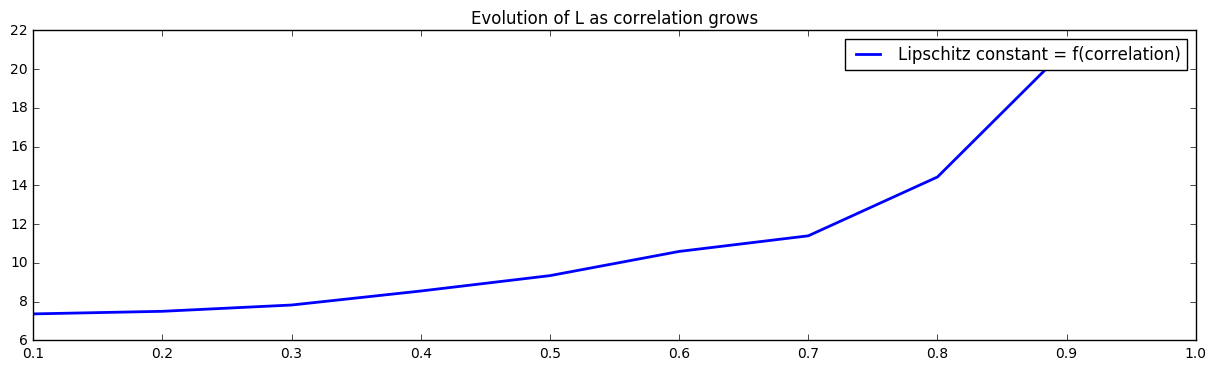

In [18]:
correlation = []
L = []

for i in range(9):
    correlation.append(0.1*(i+1))
    A_test, b_test = simu_linreg(coefs, n_samples = n, corr = correlation[i])
    L.append(lip_linreg(A_test))

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 1, 1)
plt.plot(correlation,L, label="Lipschitz constant = f(correlation)", lw=2)
plt.title("Evolution of L as correlation grows")
plt.legend()

**Answer 1 (contd.)** <br>
This plot shows us why that L is actually proportional to the correlaiton between the features. <br>
As the convergence rate is proportional to 1/L, as correlation grows so does L and 1/L shrinks as well as the proportional convergence rate.

(-2, 2)

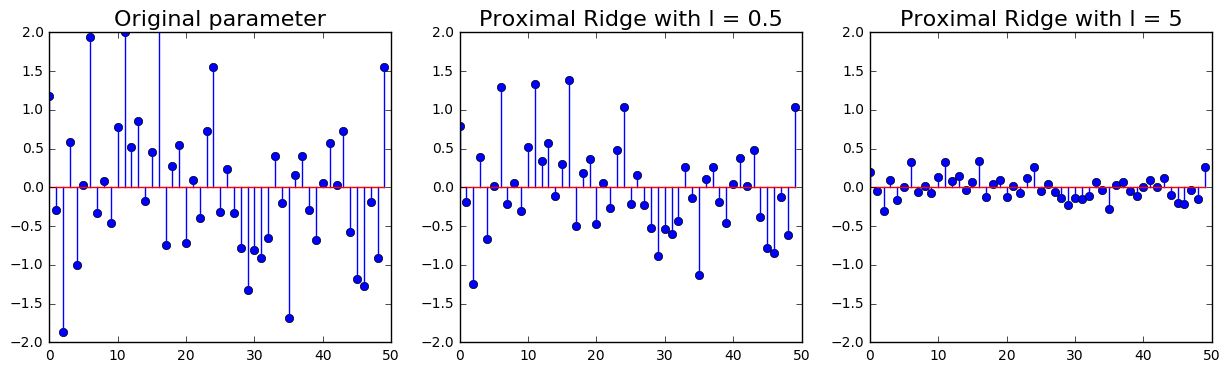

In [19]:
l_l1 = 0.5
l_l2 = 5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_ridge(x, s=l_l1))
plt.title("Proximal Ridge with l = 0.5", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_ridge(x, s=l_l2))
plt.title("Proximal Ridge with l = 5", fontsize=16)
plt.ylim([-2, 2])

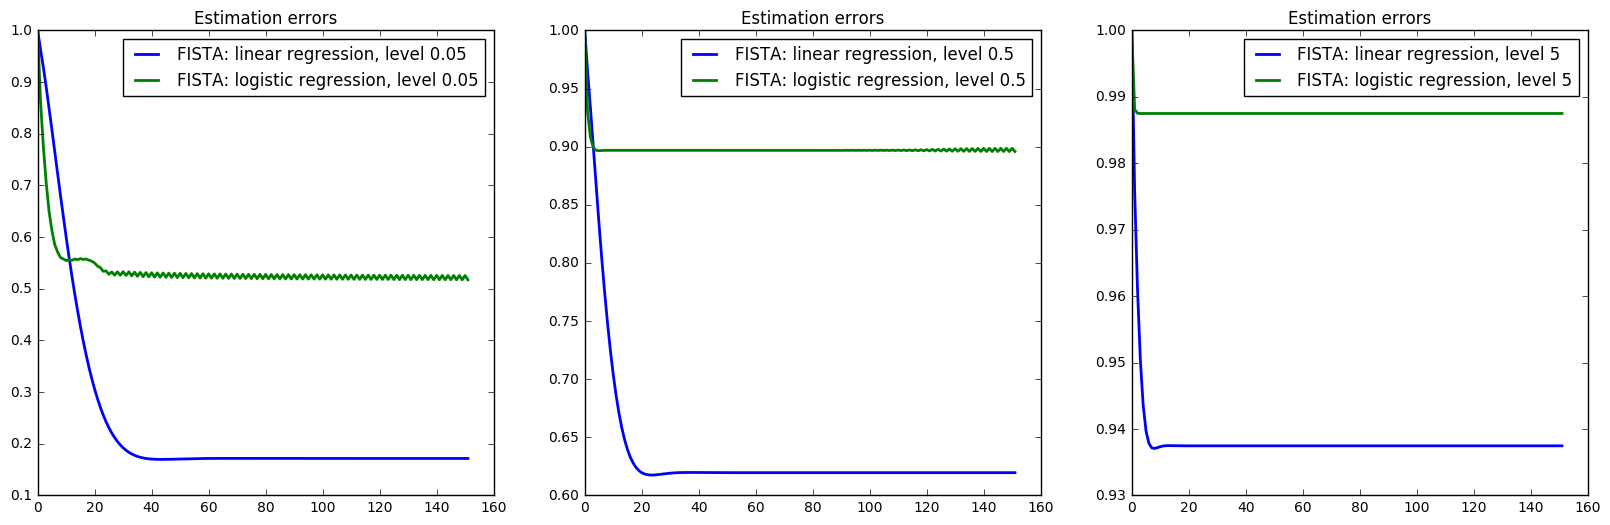

In [20]:
n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.5)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.5)
x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)


dust1, dust2, obj_lin_ridge_1, err_lin_ridge_1 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, 0.05, n_iter, coefs, False)
dust1, dust2, obj_log_ridge_1, err_log_ridge_1 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, 0.05, n_iter, coefs, False)
dust1, dust2, obj_lin_ridge_2, err_lin_ridge_2 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, 0.5, n_iter, coefs, False)
dust1, dust2, obj_log_ridge_2, err_log_ridge_2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, 0.5, n_iter, coefs, False)
dust1, dust2, obj_lin_ridge_3, err_lin_ridge_3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, 5, n_iter, coefs, False)
dust1, dust2, obj_log_ridge_3, err_log_ridge_3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, 5, n_iter, coefs, False)

plt.rcParams['figure.figsize'] = (20.0, 6.0)

plt.subplot(1, 3, 1)
plt.plot(err_lin_ridge_1, label="FISTA: linear regression, level 0.05", lw=2)
plt.title("Estimation errors")
plt.legend()

plt.subplot(1, 3, 1)
plt.plot(err_log_ridge_1, label="FISTA: logistic regression, level 0.05", lw=2)
plt.title("Estimation errors")
plt.legend()


plt.subplot(1, 3, 2)
plt.plot(err_lin_ridge_2, label="FISTA: linear regression, level 0.5", lw=2)
plt.title("Estimation errors")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(err_log_ridge_2, label="FISTA: logistic regression, level 0.5", lw=2)
plt.title("Estimation errors")
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(err_lin_ridge_3, label="FISTA: linear regression, level 5", lw=2)
plt.title("Estimation errors")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(err_log_ridge_3, label="FISTA: logistic regression, level 5", lw=2)
plt.title("Estimation errors")
plt.legend()

**Answer 2**

We made our penalization levels fluctuate from 0.05 to 0.5 and then 5. <br>
We can notice that the lower the regularization level is, the lower estimation error we get performance is obtained for both linear and logistic regressions. <br>
That is explained by the fact that a smaller regularization strength makes our parameters obtained through regression closer to the true coeficients. <br>

If the regularization est too strong, then the actual loss function is not considered enough during minimization, and the resulting regression function is unable to perform well even on the traning data. However, the opposite may also leads us to overfitting, perform to well on the training data and not be able to predict well new inputs.
Also we realized that the convergence rate gets better as the regularization strength grows.


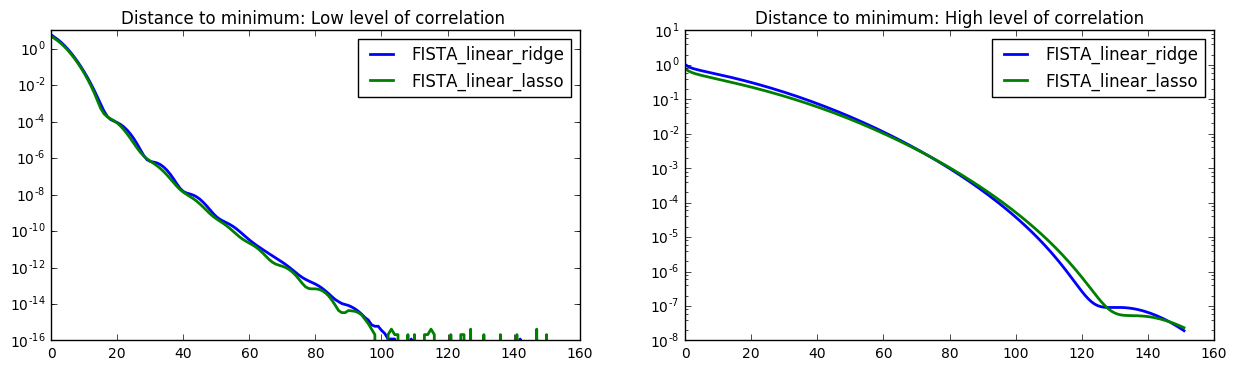

In [21]:
n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.01)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.01)

x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)

'''_LINEAR_RIDGE'''
list_x_istaR, x_istaR, obj_istaR, err_istaR = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
list_x_fistaR, x_fistaR, obj_fistaR, err_fistaR = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
'''_LINEAR_RIDGE'''

'''_LINEAR_LASSO'''
list_x_istaL, x_istaL, obj_istaL, err_istaL = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
list_x_fistaL, x_fistaL, obj_fistaL, err_fistaL = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
'''_LINEAR_LASSO'''

dust1, minimizerR, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, 1000, coefs, False)
minimumR = loss_linreg(minimizerR) + ridge(minimizerR, s)
dust1, minimizerL, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, 1000, coefs, False)
minimumL = loss_linreg(minimizerL) + lasso(minimizerL, s)

minimum_fistaR = (obj_fistaR - minimumR)/np.absolute(minimumR)
minimum_fistaL = (obj_fistaL - minimumL)/np.absolute(minimumL)

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(minimum_fistaR, label="FISTA_linear_ridge", lw=2)
plt.plot(minimum_fistaL, label="FISTA_linear_lasso", lw=2)
plt.title("Distance to minimum: Low level of correlation ")
plt.legend()

n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.8)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.8)


x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)

'''_LINEAR_RIDGE'''
list_x_istaR, x_istaR, obj_istaR, err_istaR = ista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
list_x_fistaR, x_fistaR, obj_fistaR, err_fistaR = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, n_iter, coefs, False)
'''_LINEAR_RIDGE'''

'''_LINEAR_LASSO'''
list_x_istaL, x_istaL, obj_istaL, err_istaL = ista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
list_x_fistaL, x_fistaL, obj_fistaL, err_fistaL = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, n_iter, coefs, False)
'''_LINEAR_LASSO'''

dust1, minimizerR, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, ridge, prox_ridge, step1, s, 1000, coefs, False)
minimumR = loss_linreg(minimizerR) + ridge(minimizerR, s)
dust1, minimizerL, dust2, dust3 = fista(x0, loss_linreg, grad_linreg, lasso, prox_lasso, step1, s, 1000, coefs, False)
minimumL = loss_linreg(minimizerL) + lasso(minimizerL, s)

minimum_fistaR = (obj_fistaR - minimumR)/np.absolute(minimumR)
minimum_fistaL = (obj_fistaL - minimumL)/np.absolute(minimumL)

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(minimum_fistaR, label="FISTA_linear_ridge", lw=2)
plt.plot(minimum_fistaL, label="FISTA_linear_lasso", lw=2)
plt.title("Distance to minimum: High level of correlation")
plt.legend()


**Answer 3** <br>
When the correlation between the features is strong, lasso performs less well than ridge. It is due to the fact lasso selects one features among those that are correlated and reduces the coefficients of the rest of the features to 0. Most of the time this leads to lower performances (lower convergence rates) from lasso compared to ridge, in case of highly correlated features. 

Also we saw in the previsous examples that ridge usually converges to a greater minimum than lasso. That is because ridge involves all the variables and doesn't reduces any to zero. That is why ridge is good in avoinding over fitting. 

Also, trying to make the same computations with a very high level of features, we realized that computaitonal problems are at stahe there concerning ridge. On the other hand, as lasso induces sparsity, and that coefficients that have been reduced to zero can be ignired, it seems like a much better choice in case of high dimensional problems. 

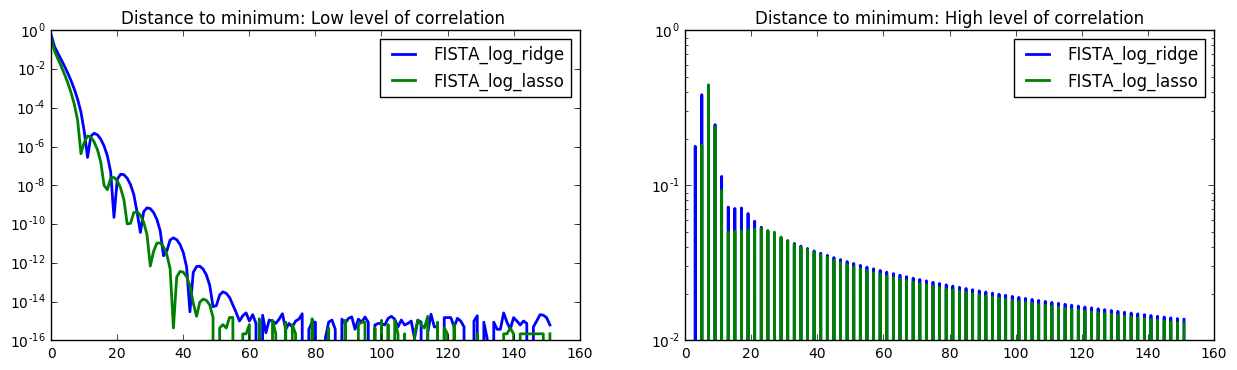

In [22]:
n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.01)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.01)

x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)

'''_LOG_RIDGE'''
list_x_istaR2, x_istaR2, obj_istaR2, err_istaR2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
list_x_fistaR2, x_fistaR2, obj_fistaR2, err_fistaR2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
'''_LOG_RIDGE'''

'''_LOG_LASSO'''
list_x_istaL2, x_istaL2, obj_istaL2, err_istaL2 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
list_x_fistaL2, x_fistaL2, obj_fistaL2, err_fistaL2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
'''_LOG_LASSO'''

dust1, minimizerR2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, 1000, coefs, False)
minimumR2 = loss_logreg(minimizerR2) + ridge(minimizerR2, s)
dust1, minimizerL2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, 1000, coefs, False)
minimumL2 = loss_logreg(minimizerL2) + lasso(minimizerL2, s)

minimum_fistaR2 = (obj_fistaR2 - minimumR2)/np.absolute(minimumR2)
minimum_fistaL2 = (obj_fistaL2 - minimumL2)/np.absolute(minimumL2)

plt.rcParams['figure.figsize'] = (15.0, 4.0)
plt.subplot(1, 2, 1)
plt.yscale('log')
plt.plot(minimum_fistaR2, label="FISTA_log_ridge", lw=2)
plt.plot(minimum_fistaL2, label="FISTA_log_lasso", lw=2)
plt.title("Distance to minimum: Low level of correlation ")
plt.legend()

n = 1000
A_lin, b_lin = simu_linreg(coefs, n_samples = n, corr = 0.8)
A_log, b_log = simu_logreg(coefs, n_samples = n, corr = 0.8)


x0 = np.zeros(n_features)
n_iter = 150
s = 1e-2
step1 = 1 / lip_linreg(A_lin)
step2 = 1 / lip_logreg(A_log)


'''_LOG_RIDGE'''
list_x_istaR2, x_istaR2, obj_istaR2, err_istaR2 = ista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
list_x_fistaR2, x_fistaR2, obj_fistaR2, err_fistaR2 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, n_iter, coefs, False)
'''_LOG_RIDGE'''

'''_LOG_LASSO'''
list_x_istaL2, x_istaL2, obj_istaL2, err_istaL2 = ista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
list_x_fistaL2, x_fistaL2, obj_fistaL2, err_fistaL2 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, n_iter, coefs, False)
'''_LOG_LASSO'''

dust1, minimizerR2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, ridge, prox_ridge, step2, s, 1000, coefs, False)
minimumR2 = loss_logreg(minimizerR2) + ridge(minimizerR2, s)
dust1, minimizerL2, dust2, dust3 = fista(x0, loss_logreg, grad_logreg, lasso, prox_lasso, step2, s, 1000, coefs, False)
minimumL2 = loss_logreg(minimizerL2) + lasso(minimizerL2, s)

minimum_fistaR2 = (obj_fistaR2 - minimumR2)/np.absolute(minimumR2)
minimum_fistaL2 = (obj_fistaL2 - minimumL2)/np.absolute(minimumL2)

plt.subplot(1, 2, 2)
plt.yscale('log')
plt.plot(minimum_fistaR2, label="FISTA_log_ridge", lw=2)
plt.plot(minimum_fistaL2, label="FISTA_log_lasso", lw=2)
plt.title("Distance to minimum: High level of correlation")
plt.legend()


Just like on the previous plot, we can tell that lasso performs better so long as the features are not too correlated.